Name of Satellite: 

NORAD name: 49155
Celestrak name: STARLINK-3060 

TLE as of 19/12/23:

    1 49155U 21082AB  23352.82880271  .00000911  00000-0  84156-4 0  9997
    2 49155  69.9995 141.4506 0002692 260.7664  99.3190 14.98335501126430

In [1]:
from skyfield.api import Topos, load, EarthSatellite
import matplotlib.pyplot as plt
from skyfield.api import Time
from datetime import datetime, timedelta
import numpy as np
import sys
import pytz
import math
from math import pow
from math import radians
import astropy.time
import astropy.coordinates
import lumos.calculator
import lumos.conversions

sys.path.append('/Users/physarah/Development/satellite-optical-brightness/analysis')


import satellite_models.diffuse_sphere as diffuse_sphere
import satellite_models.starlink_v1p5 as starlink_v1p5
%matplotlib inline

In [2]:
# tle_line1 = "STARLINK-3060"
# tle_line2 = "1 49155U 21082AB  23352.82880271  .00000911  00000-0  84156-4 0  9997"
# tle_line3 = "2 49155  69.9995 141.4506 0002692 260.7664  99.3190 14.98335501126430"

tle_line1 = "METEOR PRIRODA"          
tle_line2 = "1 12585U 81065A   24022.95282418  .00014587  00000+0  43505-3 0  9994"
tle_line3 = "2 12585  97.5623  48.0793 0009230 230.2759 129.7671 15.34718310323451"

ts = load.timescale()
#satellite = EarthSatellite(tle_line2, tle_line3, name="STARLINK-3060") 
satellite = EarthSatellite(tle_line2, tle_line3, name="ISS (ZARYA)")        

observer_location = Topos('33.7703 S', '151.1112 E', elevation_m=70) # Macquarie Observatory

In [37]:
def generate_datetime_range(start_time, end_time, interval, time_delta):
    """
    Generate a list of datetimes between start_time and end_time at a given interval.
    """
    current_time = start_time
    datetime_list = []

    while current_time <= end_time:
        datetime_list.append(current_time - timedelta(hours = time_delta))
        current_time += interval

    return datetime_list

# start_time = datetime(2023, 3, 6, 13, 25, 00)
# end_time = datetime(2023, 3, 6, 13, 27, 30)
start_time = datetime(2024, 1, 18, 9, 9, 24, 250000) - timedelta(hours=0)
end_time = datetime(2024, 1, 18, 9, 12, 31, 159000) - timedelta(hours=0)
time_interval = timedelta(seconds=1)           # Replace with your desired interval

result1 = generate_datetime_range(start_time, end_time, time_interval, time_delta=0)
result2 = generate_datetime_range(start_time, end_time, time_interval, time_delta=0)

local_datetime = np.array(result2)
utc_datetime = np.array(result1)

sat_height = np.array([(570* 1000 + 540* 1000)/2]*len(utc_datetime))

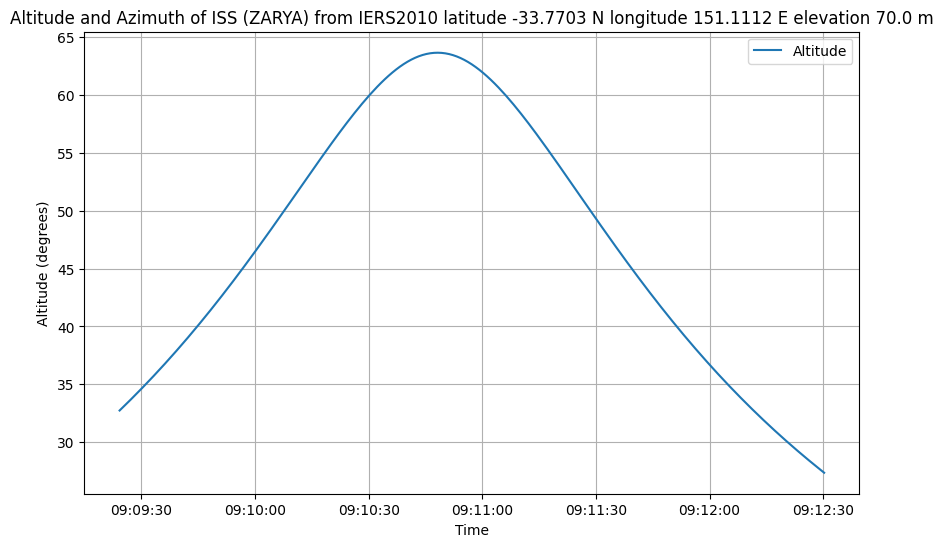

In [38]:
times = []
for timestamp_pd in local_datetime:
    TIME_PD = timestamp_pd.replace(tzinfo=pytz.utc)
    time_sf = ts.utc(TIME_PD)
    times.append(time_sf)

altitudes = []
azimuths = []
sep_angle = []
distance_list = []

for time in times:
    topocentric = (satellite - observer_location).at(time)
    satellite_position = satellite.at(time)
    satellite_position = satellite.at(time)

    observer_latitude = radians(-33.7703)  # Convert to radians
    observer_longitude = radians(151.1112)  # Convert to radians
    
    earth_radius_km = 6371.0  # Approximate Earth radius in kilometers

    delta_longitude = satellite_position.subpoint().longitude.radians - observer_longitude
    delta_latitude = satellite_position.subpoint().latitude.radians - observer_latitude

    a = (pow(math.sin(delta_latitude / 2), 2) +
         math.cos(observer_latitude) * math.cos(satellite_position.subpoint().latitude.radians) *
         pow(math.sin(delta_longitude / 2), 2))
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1 - a))
    distance_km = earth_radius_km * c
    distance_list.append(distance_km)

    alt, az, _ = topocentric.altaz()
    altitudes.append(alt.degrees)
    azimuths.append(az.degrees)
    
times_datetime = [t.utc_datetime() for t in times]

plt.figure(figsize=(10, 6))
plt.plot(times_datetime, altitudes, label="Altitude")
#plt.plot(times_datetime, azimuths, label="Azimuth")
plt.xlabel("Time")
plt.ylabel("Altitude (degrees)")
plt.legend()
plt.title(f"Altitude and Azimuth of {satellite.name} from {observer_location}")
plt.grid()
plt.show()

In [39]:
satellite_heights = sat_height
observation_times = [dt.isoformat() for dt in local_datetime]
satellite_altitudes = altitudes
satellite_azimuths = azimuths
measured_magnitudes = np.random.rand(len(satellite_azimuths))

In [40]:
mount_lemmon = astropy.coordinates.EarthLocation(lat = -33.7703, lon = 151.1112)

In [41]:
import lumos.constants as cst
cst.SUN_INTENSITY

1233

In [42]:
intensities_diffuse_sphere = np.zeros_like(measured_magnitudes)
intensities_lab_brdfs = np.zeros_like(measured_magnitudes)
intensities_inferred_brdfs = np.zeros_like(measured_magnitudes)

sun_alt_list, sun_az_list = ([],[])
for i, (sat_alt, sat_az, sat_h, time) in \
    enumerate(zip(satellite_altitudes, satellite_azimuths, satellite_heights, observation_times)):
    
    observation_time = astropy.time.Time(time, format = 'isot')
    sun_alt, sun_az = lumos.calculator.get_sun_alt_az(observation_time, mount_lemmon)
    sun_alt_list.append(sun_alt)
    sun_az_list.append(sun_az)
        
    # intensities_diffuse_sphere[i] = \
    #     diffuse_sphere.get_intensity(0.65, sat_h, sat_alt, sat_az, sun_alt, sun_az)
    
    intensities_lab_brdfs[i] = \
        lumos.calculator.get_intensity_observer_frame(
            starlink_v1p5.SURFACES_LAB_BRDFS,
            sat_h, sat_alt, sat_az, sun_alt, sun_az,
            include_earthshine = True,
            earth_panel_density=100,
            #earth_brdf=lumos.brdf.library.PHONG(0.53, 0.28, 7.31)) # use the vegitation example that Forrest uses 
            earth_brdf=lumos.brdf.library.LAMBERTIAN(0.8))
    intensities_inferred_brdfs[i] = \
        lumos.calculator.get_intensity_observer_frame(
            starlink_v1p5.SURFACES_INFER_BRDFS,
            sat_h, sat_alt, sat_az, sun_alt, sun_az,
            include_earthshine = True,
            earth_brdf=lumos.brdf.library.PHONG(0.53, 0.28, 7.31)) # use the vegitation example that Forrest uses 

#magnitudes_diffuse_sphere = lumos.conversions.intensity_to_ab_mag(intensities_diffuse_sphere)
magnitudes_lab_brdfs = lumos.conversions.intensity_to_ab_mag(intensities_lab_brdfs)
magnitudes_inferred_brdfs = lumos.conversions.intensity_to_ab_mag(intensities_inferred_brdfs)

In [43]:
import pandas as pd
iss_pandas = pd.read_csv('/Users/physarah/Desktop/METEOR_PRIRODA.csv')
#iss_pandas = iss_pandas[iss_pandas['calibed_mags']<5]
#iss_pandas = iss_pandas[iss_pandas['altitude']>55]

datetime_iss = []
for i in pd.to_datetime(iss_pandas['utc']):
    datetime_iss.append(i.to_pydatetime())

datetime_iss2 = []
for i in datetime_iss:
    datetime_iss2.append(i)

In [36]:
datetime_iss2[-1]

datetime.datetime(2024, 1, 18, 9, 12, 31, 159000)

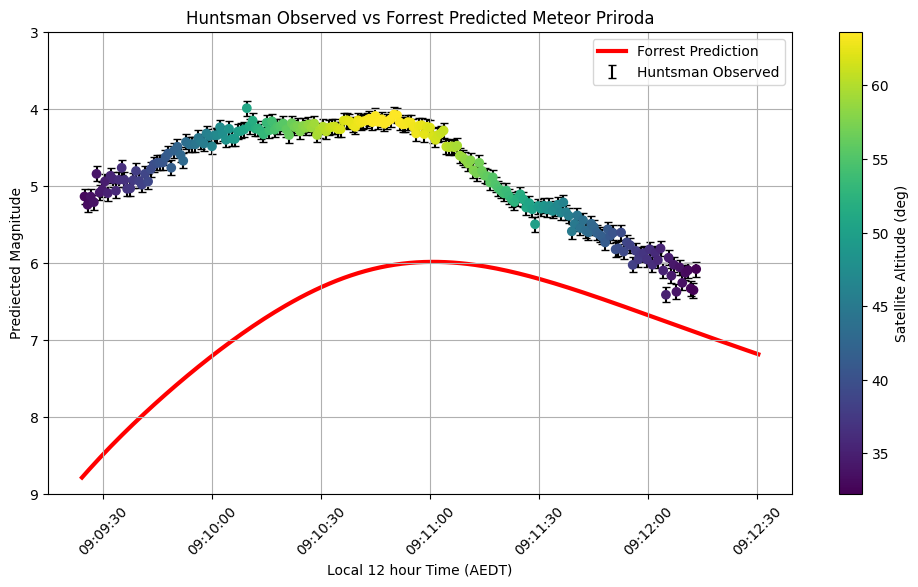

In [58]:
plt.figure(figsize=(12, 6))
plt.errorbar(datetime_iss2[0:-24], 
             iss_pandas['calibed_mags'][0:-24], 
             yerr=[np.sqrt(0.08369540784858925**2 + 0.05**2)]*len(iss_pandas['calibed_mags'][0:-24]), 
             ls = '', c = 'black', capsize = 3, zorder = 1, label = 'Huntsman Observed')
plt.scatter(datetime_iss2[0:-24], iss_pandas['calibed_mags'][0:-24], c = iss_pandas['altitude'][0:-24], zorder = 2)
plt.plot(times_datetime, magnitudes_lab_brdfs, label = 'Forrest Prediction', color = 'red', ls = '-', lw = 3, zorder = 0)
plt.colorbar(label = "Satellite Altitude (deg)")
#plt.axhline(-4.6, label = "Venus Magnitude", ls = '--')
#plt.plot(times_datetime, azimuths, label="Azimuth")
plt.xlabel("Local 12 hour Time (AEDT)")
plt.legend()
plt.ylabel("Prediected Magnitude")
plt.ylim(9,3)
plt.title("Huntsman Observed vs Forrest Predicted Meteor Priroda")
plt.grid(True)
#plt.xlim(datetime(2024, 1, 18, 6, 31, 0),datetime(2024, 1, 18, 6, 32, 30))
plt.xticks(rotation = 45)
plt.savefig('/Users/physarah/Desktop/Meteor_Priroda_v2.png')

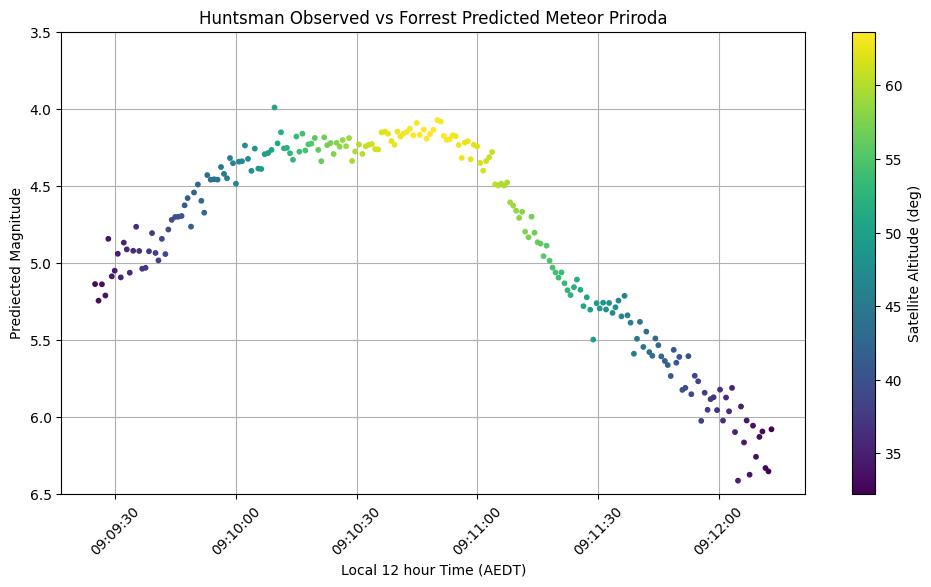

In [65]:
plt.figure(figsize=(12, 6))
# plt.errorbar(datetime_iss2[0:-24], 
#              iss_pandas['calibed_mags'][0:-24], 
#              yerr=[np.sqrt(0.08369540784858925**2 + 0.05**2)]*len(iss_pandas['calibed_mags'][0:-24]), 
#              ls = '', c = 'black', capsize = 3, zorder = 1, label = 'Huntsman Observed')
plt.scatter(datetime_iss2[0:-24], iss_pandas['calibed_mags'][0:-24], c = iss_pandas['altitude'][0:-24], zorder = 2, s = 10)
plt.colorbar(label = "Satellite Altitude (deg)")
#plt.axhline(-4.6, label = "Venus Magnitude", ls = '--')
#plt.plot(times_datetime, azimuths, label="Azimuth")
plt.xlabel("Local 12 hour Time (AEDT)")
plt.ylabel("Prediected Magnitude")
plt.ylim(6.5,3.5)
plt.title("Huntsman Observed vs Forrest Predicted Meteor Priroda")
plt.grid(True)
#plt.xlim(datetime(2024, 1, 18, 6, 31, 0),datetime(2024, 1, 18, 6, 32, 30))
plt.xticks(rotation = 45)
plt.savefig('/Users/physarah/Desktop/Meteor_Priroda_v3.png')

[1.0, 0.0, 4.898587196589413e-17]
[6.123233995736766e-17, 1.0, 4.898587196589413e-17]
[-1.0, 1.2246467991473532e-16, 4.898587196589413e-17]
[-1.8369701987210297e-16, -1.0, 4.898587196589413e-17]


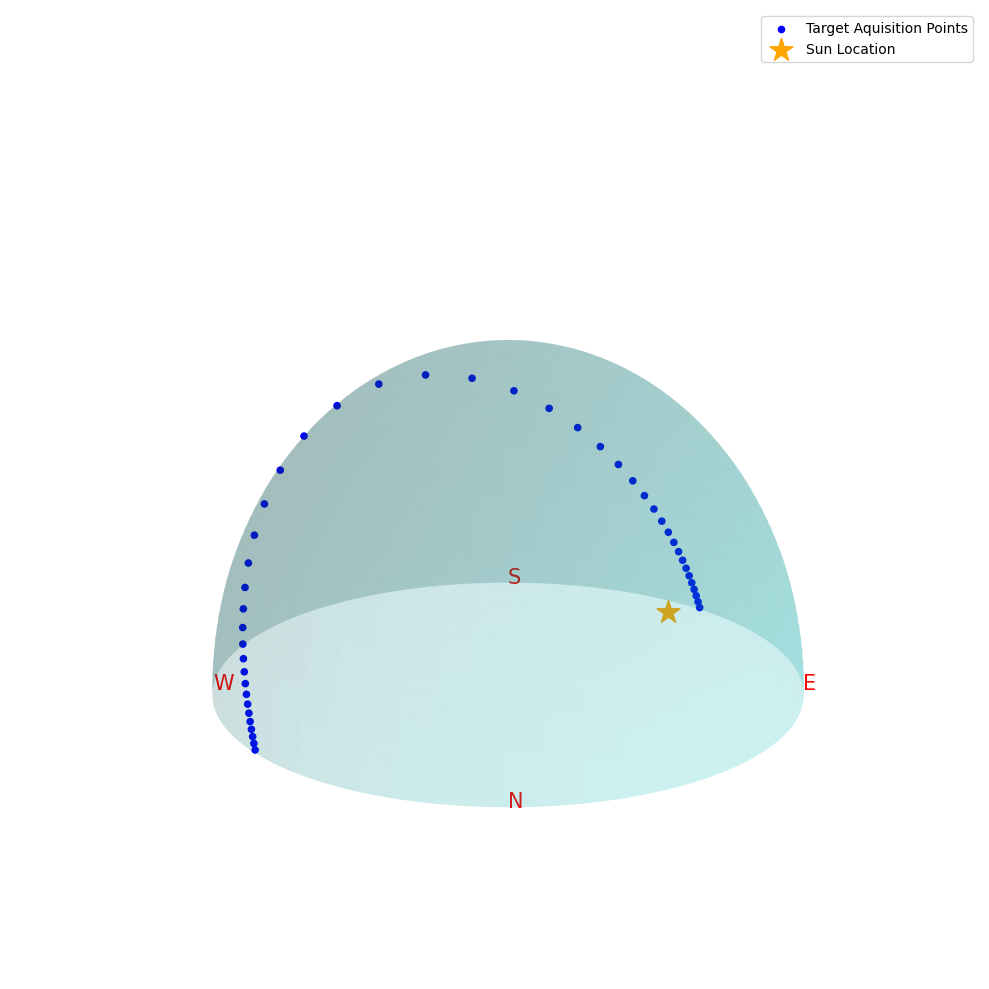

In [74]:
import matplotlib.pyplot as plt
import numpy as np
import astropy.units as u
from mpl_toolkits.mplot3d import Axes3D
%matplotlib ipympl
%matplotlib inline

# Sample data (replace with your actual data)
altitude = [30, 60, 90, 45, 30]  # Example altitude values in degrees
azimuth = [45, 90, 180, 270, 360]  # Example azimuth values in degrees

# Convert altitude and azimuth to radians
altitude_rad = np.array((satellite_altitudes*u.deg).to(u.rad))
azimuth_rad = np.array((satellite_azimuths*u.deg).to(u.rad))
    
# Create a 3D plot with polar projection for azimuth
fig = plt.figure(figsize = (10,10))
ax = fig.add_subplot(111, projection='3d')
ax.view_init(elev=20, azim=0)

# Plot hemisphere surface
phi, theta = np.mgrid[0.0:0.5*np.pi:1000j, 0.0:2.0*np.pi:1000j]
#phi, theta = np.mgrid[0.0:np.pi:1000j, 0.0:2.0*np.pi:1000j]

x = np.sin(phi) * np.cos(theta)
y = np.sin(phi) * np.sin(theta)
z = 0.8*np.cos(phi)
ax.plot_surface(x, y, z, color='c', alpha=0.2)

# Plot satellite transit on the hemisphere
x_transit = np.sin(np.pi / 2 - altitude_rad) * np.cos(azimuth_rad)
y_transit = np.sin(np.pi / 2 - altitude_rad) * np.sin(azimuth_rad)
z_transit = np.cos(np.pi / 2 - altitude_rad)
ax.scatter(x_transit, y_transit, 0.8*z_transit, color='b', label='Target Aquisition Points', alpha = 1, marker = 'o')

# # Plot satellite transit on the hemisphere
# x_transit = np.sin(np.pi / 2 - np.array(altitudes)) * np.cos(np.array(azimuths))
# y_transit = np.sin(np.pi / 2 - np.array(altitudes)) * np.sin(np.array(azimuths))
# z_transit = np.cos(np.pi / 2 - np.array(altitudes))
# ax.plot(x_transit, y_transit, 0.8*z_transit, color='black', label='Satellite Transit Path')

x_transit_sun = np.sin(np.pi / 2 - sun_alt) * np.cos(sun_az)
y_transit_sun = np.sin(np.pi / 2 - sun_alt) * np.sin(sun_az)
z_transit_sun = np.cos(np.pi / 2 - sun_alt)
ax.scatter(x_transit_sun, y_transit_sun, 0.8*z_transit_sun, color='orange', s=300, label='Sun Location', zorder = 10, marker = '*')


azes = np.array(([0,90,180,270]*u.deg).to(u.rad).value)
alts = np.array(([0,0,0,0]*u.deg).to(u.rad).value)
x_transit = np.sin(np.pi / 2 - alts) * np.cos(azes)
y_transit = np.sin(np.pi / 2 - alts) * np.sin(azes)
z_transit = 0.8*np.cos(np.pi / 2 - alts)
# direction = ['N', 'E', 'S', 'W']
# ax.text(x_transit, y_transit, z_transit, direction, color='r', ha='center', va='center', fontsize=8)#, rotation=90)

# Plot cardinal directions
cardinal_directions = {'N': [x_transit[0],y_transit[0],z_transit[0]],
                       'E': [x_transit[1],y_transit[1],z_transit[1]],
                       'S': [x_transit[2],y_transit[2],z_transit[2]],
                       'W': [x_transit[3],y_transit[3],z_transit[3]]}
for direction, angle in cardinal_directions.items():
    print(angle)
    ax.text(angle[0], angle[1], angle[2], direction, fontsize=15, color='r')

    
# Set plot limits
ax.set_xlim(-1, 1)
ax.set_ylim(-1, 1)
ax.set_zlim(0, 1)

# Set axis labels
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

# Add a legend
ax.legend()
ax.axis(False)
# Show the plot
plt.tight_layout()
plt.savefig("/Users/physarah/Desktop/sat_path2.png")

In [96]:
pd.to_datetime(iss_pandas['utc'])[0].to_pydatetime()

datetime.datetime(2023, 3, 6, 1, 25, 6)

In [94]:
type(times_datetime[0])

datetime.datetime

In [142]:
iss_pandas.columns

Index(['Unnamed: 0', 'datetime', 'target_sum', 'exposure_time', 'sky_mean',
       'm_inst', 'm_inst_sky', 'calibed_mags', 'airmass', 'altitude',
       'azimuth', 'utc', 'zenith_angle', 'km_distance'],
      dtype='object')